# final GODE code(paper)

SEOYEON CHOI  
2023-08-16

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go
import copy 

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from sklearn import svm
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from alibi_detect.od import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from sklearn.svm import OneClassSVM

2023-08-07 21:25:38.789152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

# Simulation

## Class Code

In [2]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)

In [3]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [4]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [5]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

## Linear

In [6]:
np.random.seed(6)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon

In [7]:
outlier_true_one_1 = signal.copy()

In [8]:
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

In [9]:
x_1 = np.linspace(0,2,1000)
y1_1 = 5 * x_1
y_1 = y1_1 + eta # eta = signal + epsilon

In [10]:
_df=pd.DataFrame({'x':x_1, 'y':y_1})

### GODE

In [11]:
w=np.zeros((1000,1000))

In [12]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [13]:
_Linear = Linear(_df)

In [14]:
_Linear.fit(sd=20)

In [15]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()

In [16]:
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [17]:
outlier_simul_one.count(1)

In [18]:
outlier_simul_one.count(-1)

In [19]:
_conf = Conf_matrx(outlier_true_one_1,outlier_simul_one)

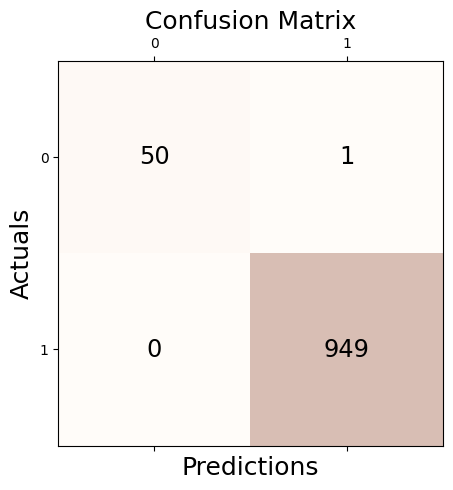

Accuracy: 0.999
Precision: 0.999
Recall: 1.000
F1 Score: 0.999

In [20]:
_conf.conf("GODE")

### LOF

In [21]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [22]:
_conf = Conf_matrx(outlier_true_one_1,clf.fit_predict(_df))

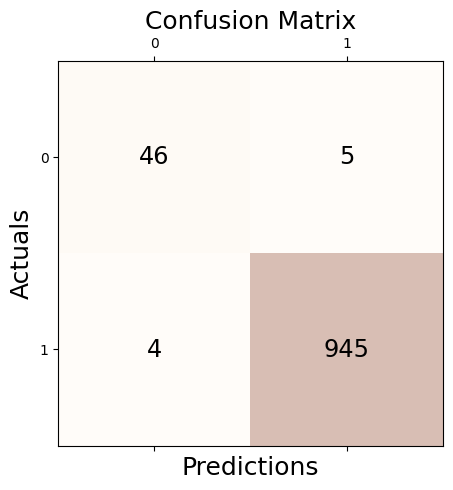

Accuracy: 0.991
Precision: 0.995
Recall: 0.996
F1 Score: 0.995

In [23]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [24]:
from pyod.models.knn import KNN

In [25]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['knn_Clf'] = clf.labels_

In [26]:
outlier_KNN_one = list(clf.labels_)

In [27]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [28]:
_conf = Conf_matrx(outlier_true_one_1,outlier_KNN_one)

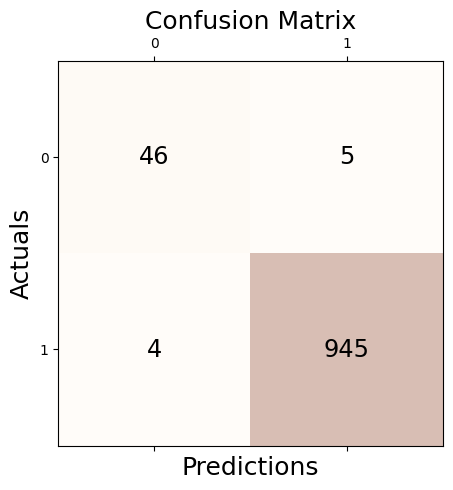

Accuracy: 0.991
Precision: 0.995
Recall: 0.996
F1 Score: 0.995

In [29]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [30]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [31]:
outlier_CBLOF_one = list(clf.labels_)

In [32]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [33]:
_conf = Conf_matrx(outlier_true_one_1,outlier_CBLOF_one)

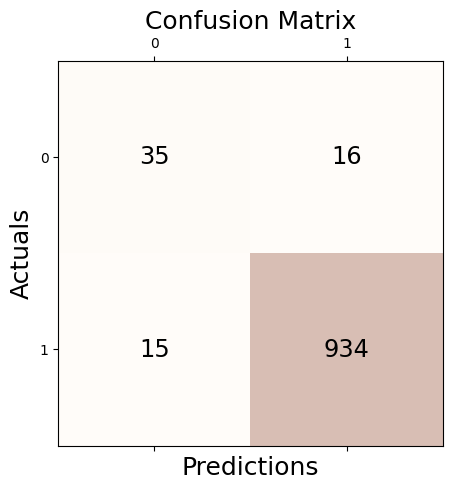

Accuracy: 0.969
Precision: 0.983
Recall: 0.984
F1 Score: 0.984

In [34]:
_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [35]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [36]:
clf.fit(_df)

In [37]:
outlier_OSVM_one = list(clf.predict(_df))

In [38]:
_conf = Conf_matrx(outlier_true_one_1,outlier_OSVM_one)

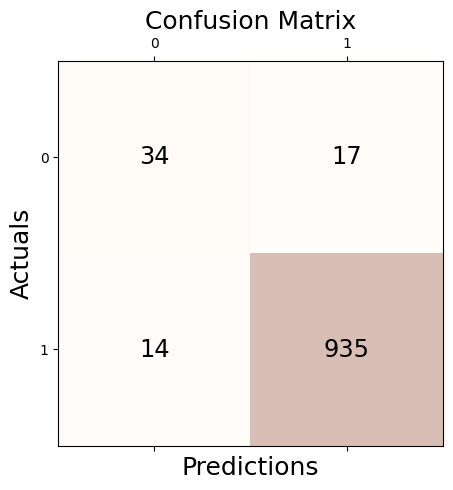

Accuracy: 0.969
Precision: 0.982
Recall: 0.985
F1 Score: 0.984

In [39]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [40]:
clf = MCD(contamination=0.05, random_state = 77)
clf.fit(_df[['x', 'y']])
_df['MCD_clf'] = clf.labels_

In [41]:
outlier_MCD_one = list(clf.labels_)

In [42]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [43]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MCD_one)

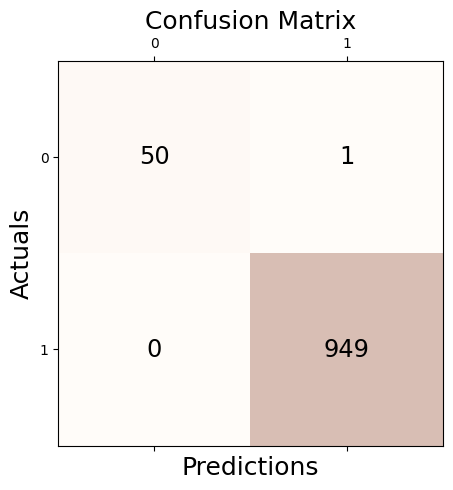

Accuracy: 0.999
Precision: 0.999
Recall: 1.000
F1 Score: 0.999

In [44]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [45]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])
_df['FeatureBagging_clf'] = clf.labels_

In [46]:
outlier_FeatureBagging_one = list(clf.labels_)

In [47]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [48]:
_conf = Conf_matrx(outlier_true_one_1,outlier_FeatureBagging_one)

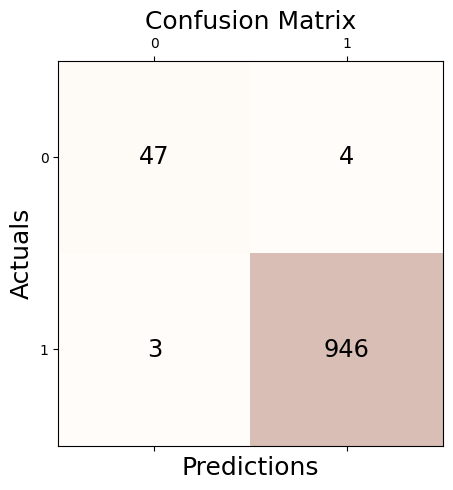

Accuracy: 0.993
Precision: 0.996
Recall: 0.997
F1 Score: 0.996

In [49]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [50]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = clf.labels_

In [51]:
outlier_ABOD_one = list(clf.labels_)

In [52]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [53]:
_conf = Conf_matrx(outlier_true_one_1,outlier_ABOD_one)

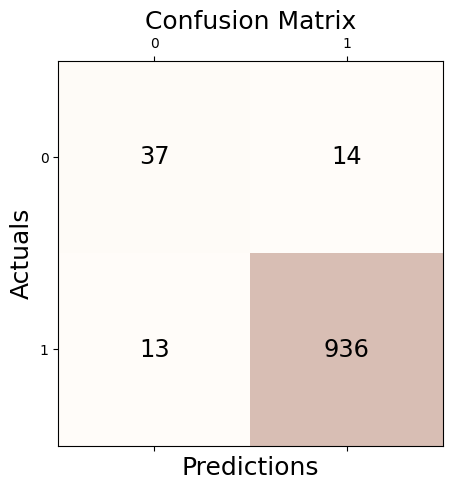

Accuracy: 0.973
Precision: 0.985
Recall: 0.986
F1 Score: 0.986

In [54]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [55]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [56]:
od.fit(_df[['x', 'y']])

In [57]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

In [58]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [59]:
outlier_alibi_one = _df['IF_alibi']

In [60]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [61]:
_conf = Conf_matrx(outlier_true_one_1,outlier_alibi_one)

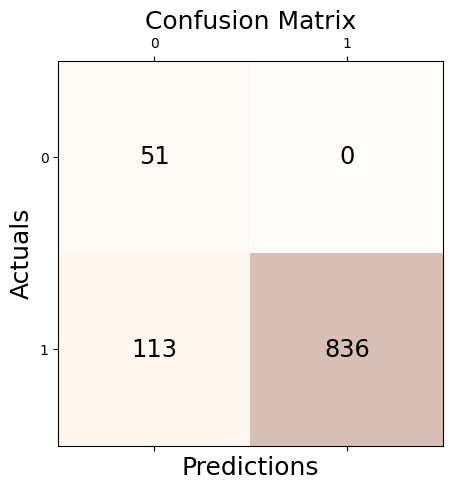

Accuracy: 0.887
Precision: 1.000
Recall: 0.881
F1 Score: 0.937

In [62]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [63]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['HBOS_clf'] = clf.labels_

In [64]:
outlier_HBOS_one = list(clf.labels_)

In [65]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [66]:
_conf = Conf_matrx(outlier_true_one_1,outlier_HBOS_one)

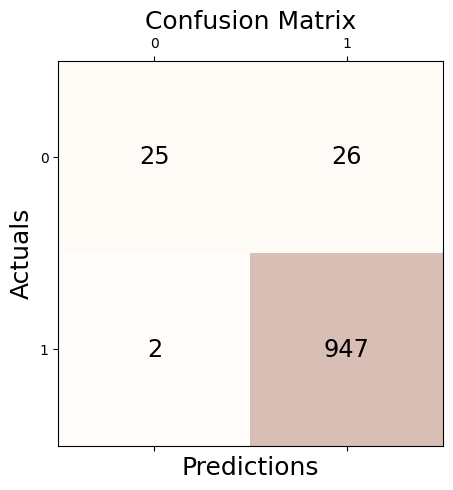

Accuracy: 0.972
Precision: 0.973
Recall: 0.998
F1 Score: 0.985

In [67]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [68]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['SOS_clf'] = clf.labels_

In [69]:
outlier_SOS_one = list(clf.labels_)

In [70]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [71]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SOS_one)

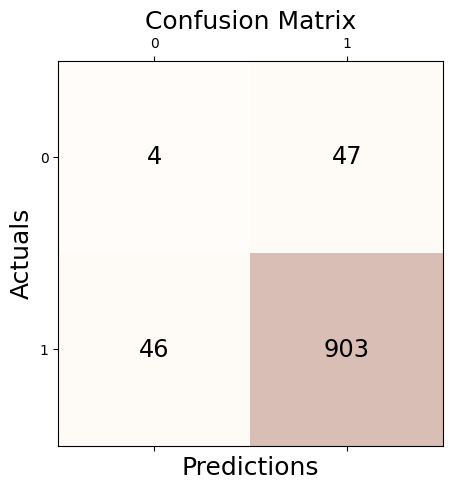

Accuracy: 0.907
Precision: 0.951
Recall: 0.952
F1 Score: 0.951

In [72]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [73]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['SO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [74]:
outlier_SO_GAAL_one = list(clf.labels_)

In [75]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [76]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SO_GAAL_one)

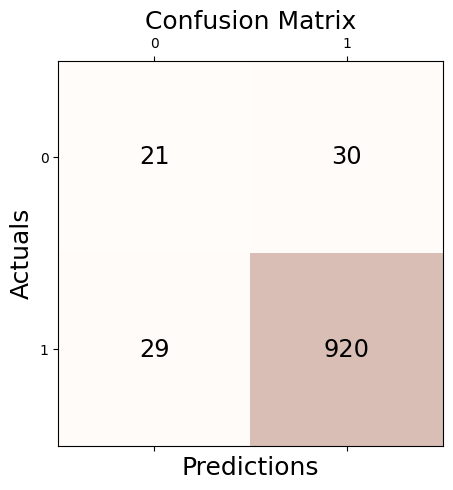

Accuracy: 0.941
Precision: 0.968
Recall: 0.969
F1 Score: 0.969

In [77]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [78]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 1 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 2 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 3 index 2:
32/32 [==============================] - 0s 644us/step
Epoch 4 of 60

Testing for epoch 4 index 1:
32/32 [==============================] - 0s 659us/step

Testing for epoch 4 index 2:
32/32 [==============================] - 0s 2ms/step
Epoch 5 of 60

Testing for epoch 5 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 5 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 6 of 60

Testing for epoch 6 index 1:
32/32 [==============================] - 0s 1ms/step

In [79]:
outlier_MO_GAAL_one = list(clf.labels_)

In [80]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [81]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MO_GAAL_one)

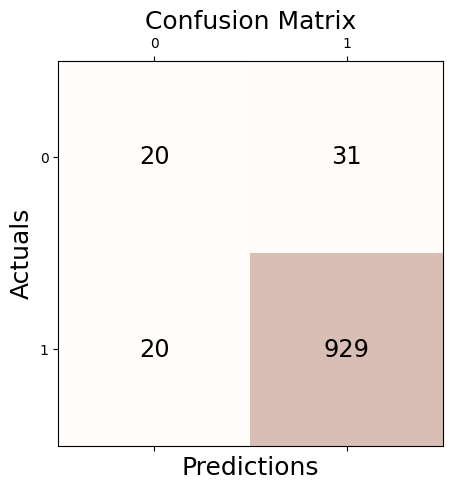

Accuracy: 0.949
Precision: 0.968
Recall: 0.979
F1 Score: 0.973

In [82]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [83]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())

In [84]:
outlier_LSCP_one = list(clf.labels_)

In [85]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [86]:
_conf = Conf_matrx(outlier_true_one_1,outlier_LSCP_one)

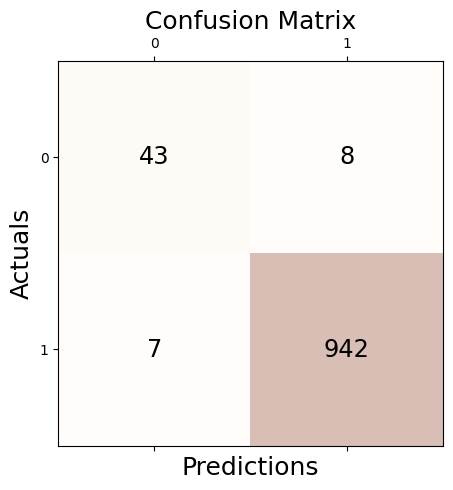

Accuracy: 0.985
Precision: 0.992
Recall: 0.993
F1 Score: 0.992

In [87]:
_conf.conf("LSCP (Zhao et al., 2019)")

## Orbit

In [88]:
np.random.seed(1212)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon

In [89]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta

In [90]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [91]:
outlier_true_one = signal.copy()

In [92]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

### GODE

In [93]:
_Orbit = Orbit(_df)

In [94]:
_Orbit.get_distance()

100%|██████████| 1000/1000 [00:03<00:00, 265.48it/s]

In [95]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 

In [96]:
_Orbit.fit(sd=15,ref=20)

In [97]:
outlier_simul_one = (_Orbit.df['Residual']**2).tolist()

In [98]:
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [99]:
outlier_simul_one.count(1)

In [100]:
outlier_simul_one.count(-1)

In [101]:
_conf = Conf_matrx(outlier_true_one,outlier_simul_one)

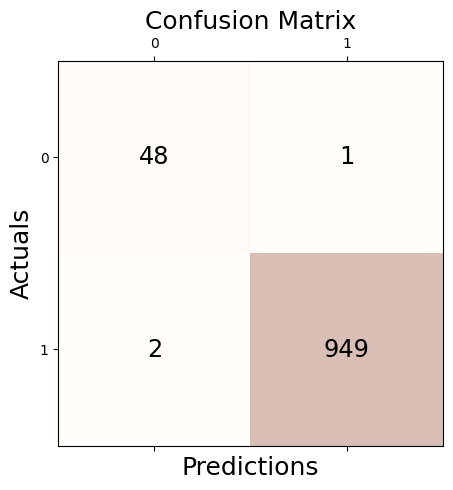

Accuracy: 0.997
Precision: 0.999
Recall: 0.998
F1 Score: 0.998

In [102]:
_conf.conf("GODE")

### LOF

In [103]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [104]:
_conf = Conf_matrx(outlier_true_one,clf.fit_predict(_df))

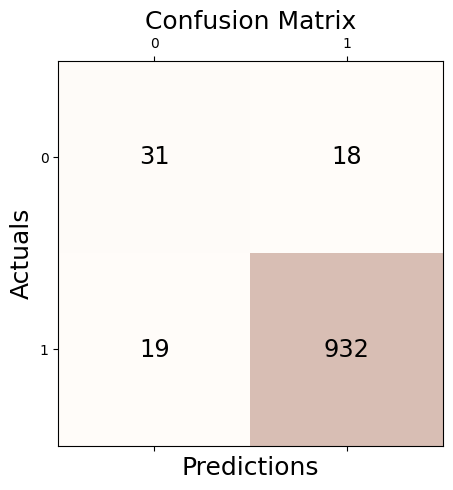

Accuracy: 0.963
Precision: 0.981
Recall: 0.980
F1 Score: 0.981

In [105]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [106]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['knn_clf'] = clf.labels_

In [107]:
outlier_KNN_one = list(clf.labels_)

In [108]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [109]:
_conf = Conf_matrx(outlier_true_one,outlier_KNN_one)

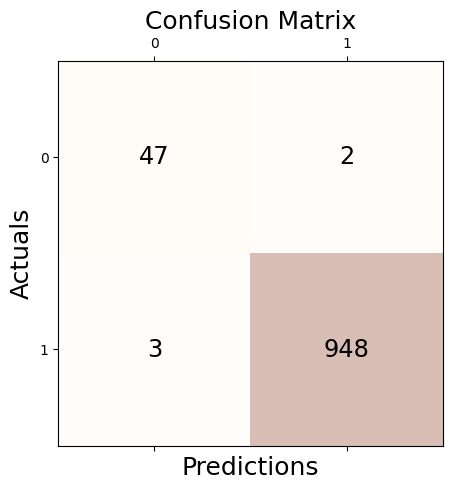

Accuracy: 0.995
Precision: 0.998
Recall: 0.997
F1 Score: 0.997

In [110]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [111]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['CBLOF_Clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [112]:
outlier_CBLOF_one = list(clf.labels_)

In [113]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [114]:
_conf = Conf_matrx(outlier_true_one,outlier_CBLOF_one)

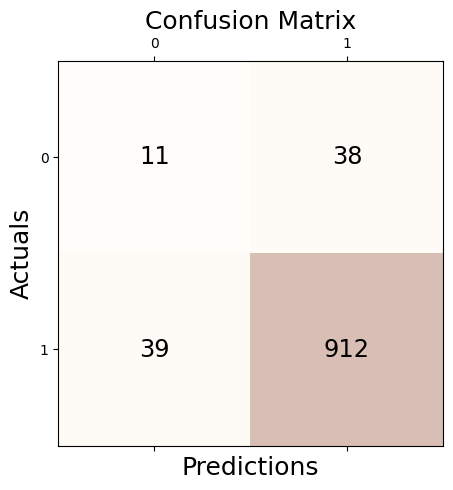

Accuracy: 0.923
Precision: 0.960
Recall: 0.959
F1 Score: 0.959

In [115]:
_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [116]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [117]:
clf.fit(_df)

In [118]:
outlier_OSVM_one = list(clf.predict(_df))

In [119]:
_conf = Conf_matrx(outlier_true_one,outlier_OSVM_one)

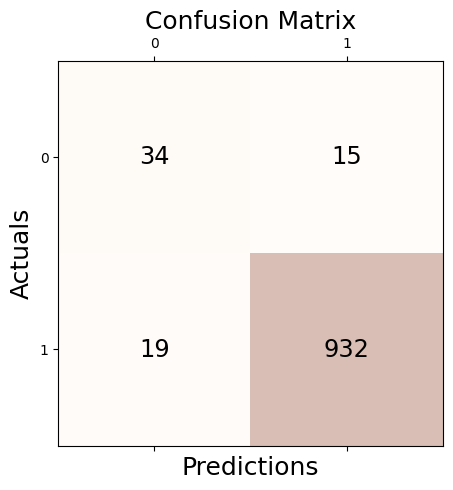

Accuracy: 0.966
Precision: 0.984
Recall: 0.980
F1 Score: 0.982

In [120]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [121]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x', 'y','f']])
_df['MCD_clf'] = clf.labels_

In [122]:
outlier_MCD_one = list(clf.labels_)

In [123]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [124]:
_conf = Conf_matrx(outlier_true_one,outlier_MCD_one)

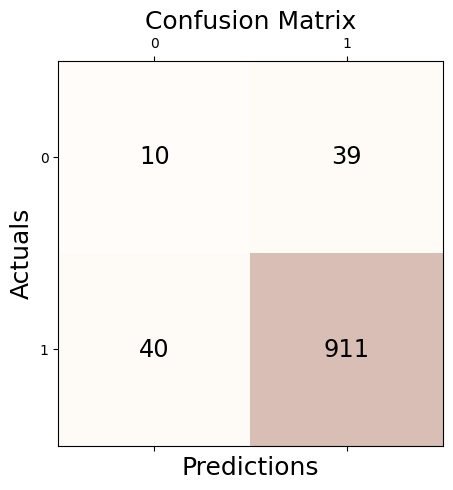

Accuracy: 0.921
Precision: 0.959
Recall: 0.958
F1 Score: 0.958

In [125]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [126]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['FeatureBagging_clf'] = clf.labels_

In [127]:
outlier_FeatureBagging_one = list(clf.labels_)

In [128]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [129]:
_conf = Conf_matrx(outlier_true_one,outlier_FeatureBagging_one)

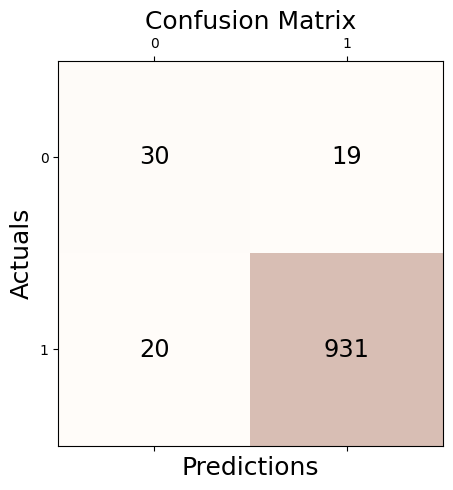

Accuracy: 0.961
Precision: 0.980
Recall: 0.979
F1 Score: 0.979

In [130]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [131]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['ABOD_Clf'] = clf.labels_

In [132]:
outlier_ABOD_one = list(clf.labels_)

In [133]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [134]:
_conf = Conf_matrx(outlier_true_one,outlier_ABOD_one)

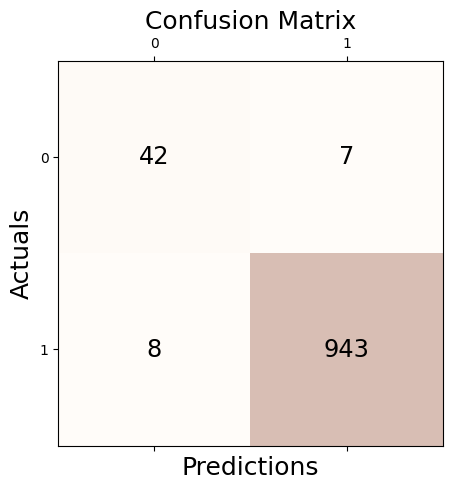

Accuracy: 0.985
Precision: 0.993
Recall: 0.992
F1 Score: 0.992

In [135]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [136]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [137]:
od.fit(_df[['x', 'y','f']])

In [138]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

In [139]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [140]:
outlier_alibi_one = _df['IF_alibi']

In [141]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [142]:
_conf = Conf_matrx(outlier_true_one,outlier_alibi_one)

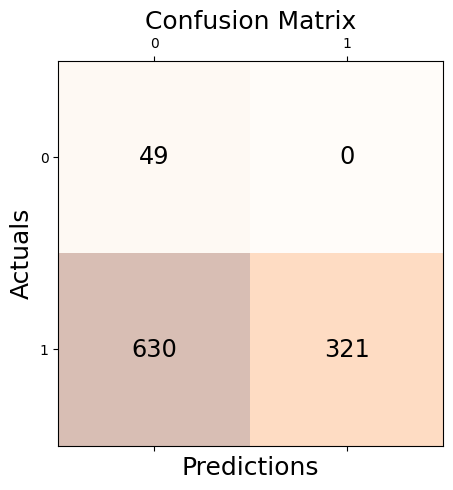

Accuracy: 0.370
Precision: 1.000
Recall: 0.338
F1 Score: 0.505

In [143]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [144]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['HBOS_clf'] = clf.labels_

In [145]:
outlier_HBOS_one = list(clf.labels_)

In [146]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [147]:
_conf = Conf_matrx(outlier_true_one,outlier_HBOS_one)

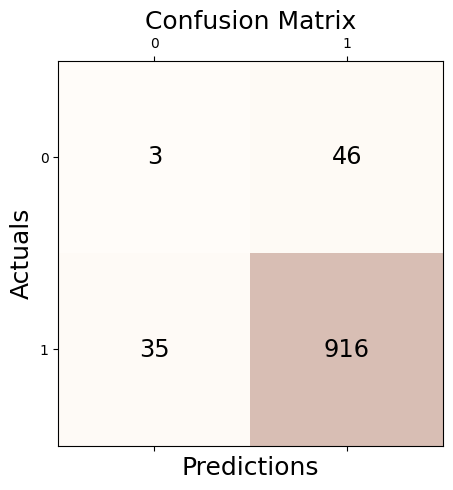

Accuracy: 0.919
Precision: 0.952
Recall: 0.963
F1 Score: 0.958

In [148]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [149]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['SOS_clf'] = clf.labels_

In [150]:
outlier_SOS_one = list(clf.labels_)

In [151]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [152]:
_conf = Conf_matrx(outlier_true_one,outlier_SOS_one)

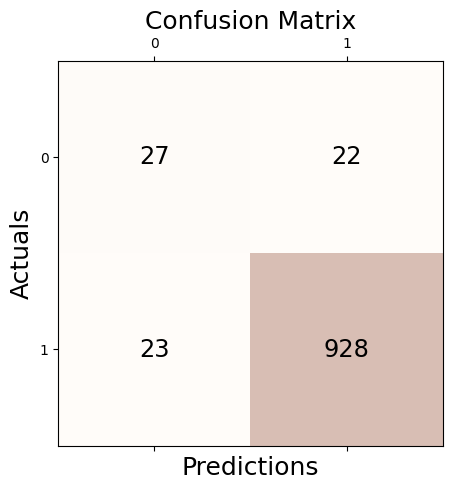

Accuracy: 0.955
Precision: 0.977
Recall: 0.976
F1 Score: 0.976

In [153]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [154]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

In [155]:
outlier_SO_GAAL_one = list(clf.labels_)

In [156]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [157]:
_conf = Conf_matrx(outlier_true_one,outlier_SO_GAAL_one)

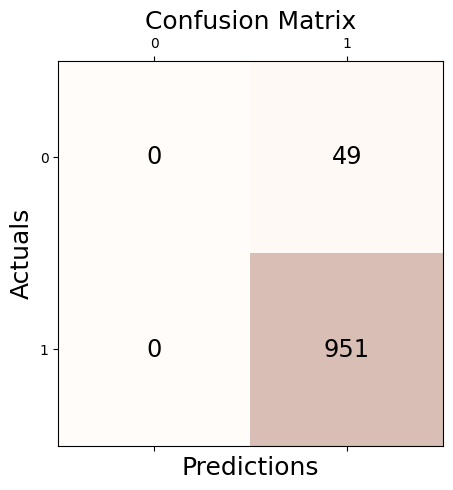

Accuracy: 0.951
Precision: 0.951
Recall: 1.000
F1 Score: 0.975

In [158]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [159]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 1 index 2:
32/32 [==============================] - 0s 4ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 2 index 2:
32/32 [==============================] - 0s 3ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 3 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 4 of 60

Testing for epoch 4 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 4 index 2:
32/32 [==============================] - 0s 2ms/step
Epoch 5 of 60

Testing for epoch 5 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 5 index 2:
32/32 [==============================] - 0s 2ms/step
Epoch 6 of 60

Testing for epoch 6 index 1:
32/32 [==============================] - 0s 2ms/step

Te

In [160]:
outlier_MO_GAAL_one = list(clf.labels_)

In [161]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [162]:
_conf = Conf_matrx(outlier_true_one,outlier_MO_GAAL_one)

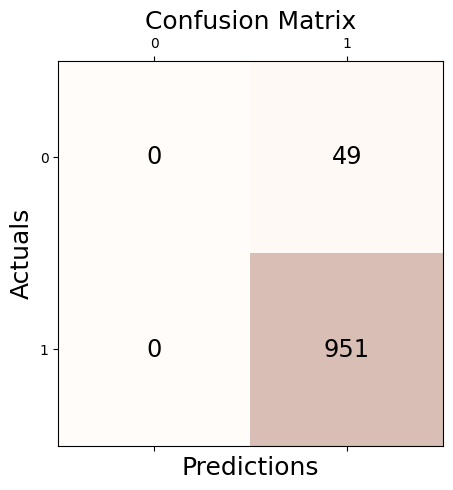

Accuracy: 0.951
Precision: 0.951
Recall: 1.000
F1 Score: 0.975

In [163]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [164]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [165]:
outlier_LSCP_one = list(clf.labels_)

In [166]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [167]:
_conf = Conf_matrx(outlier_true_one,outlier_LSCP_one)

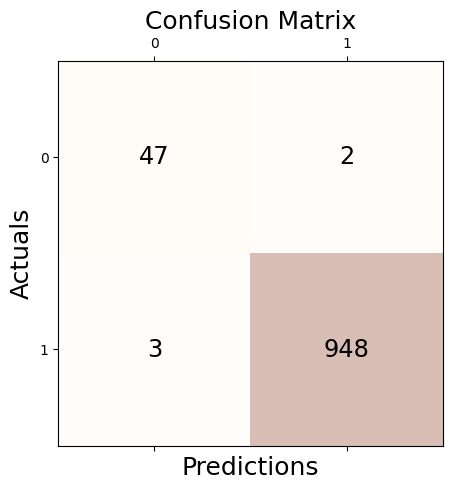

Accuracy: 0.995
Precision: 0.998
Recall: 0.997
F1 Score: 0.997

In [168]:
_conf.conf("LSCP (Zhao et al., 2019)")

## Bunny

In [169]:
G = graphs.Bunny()
n = G.N

In [170]:
g = filters.Heat(G, tau=75) 

In [171]:
n=2503

In [172]:
np.random.seed(1212)
normal = np.around(np.random.normal(size=n),15)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif

In [173]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2023-08-07 21:36:53,380:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.

In [174]:
G.coords.shape

In [175]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [176]:
_df1 = {'W':_W,'x':_x,'y':_y,'z':_z, 'fnoise':f+noise,'f' : f, 'noise': noise,'unif':unif}

In [177]:
_df = pd.DataFrame({'x': _df1['x'],'y':_df1['y'],'z':_df1['z'],'fnoise':_df1['fnoise'],'f':_df1['f'],'noise':_df1['noise']})

In [178]:
unif = _df1['unif']

In [179]:
outlier_true_one_2 = unif.copy()

In [180]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

In [181]:
X = np.array(_df)[:,:4]

### GODE

In [182]:
_W = _df1['W']

In [183]:
_BUNNY = BUNNY(_df)

In [184]:
_BUNNY.fit(sd=20,ref=10)

In [185]:
len(_BUNNY.f)

In [186]:
2503*0.05

In [187]:
outlier_simul_one = (_BUNNY.df['Residual']**2).tolist()

In [188]:
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [189]:
outlier_simul_one.count(1)

In [190]:
outlier_simul_one.count(-1)

In [191]:
_conf = Conf_matrx(outlier_true_one_2,outlier_simul_one)

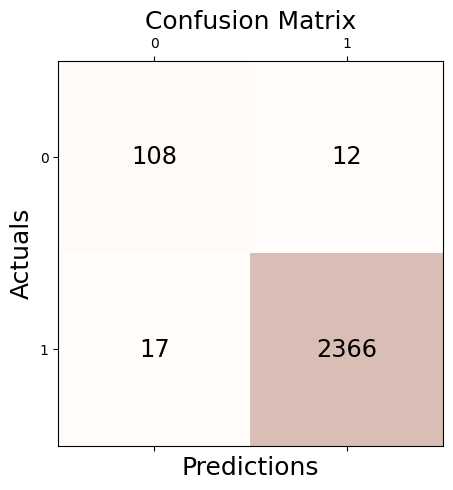

Accuracy: 0.988
Precision: 0.995
Recall: 0.993
F1 Score: 0.994

In [192]:
_conf.conf("GODE")

### LOF

In [193]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [194]:
_conf = Conf_matrx(outlier_true_one_2,clf.fit_predict(X))

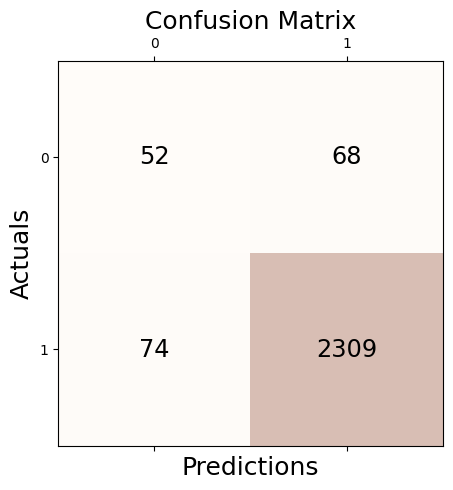

Accuracy: 0.943
Precision: 0.971
Recall: 0.969
F1 Score: 0.970

In [195]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [196]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['knn_Clf'] = clf.labels_

In [197]:
outlier_KNN_one = list(clf.labels_)

In [198]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [199]:
_conf = Conf_matrx(outlier_true_one_2,outlier_KNN_one)

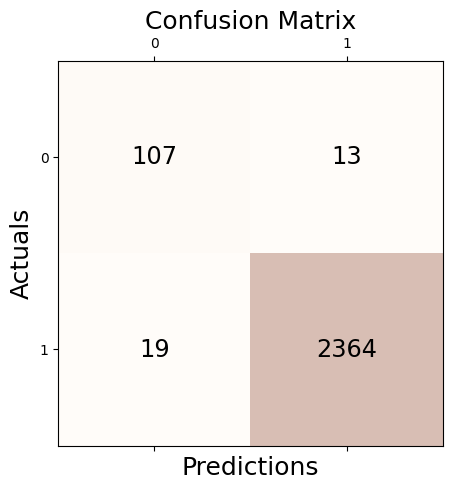

Accuracy: 0.987
Precision: 0.995
Recall: 0.992
F1 Score: 0.993

In [200]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [201]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['CBLOF_Clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [202]:
outlier_CBLOF_one = list(clf.labels_)

In [203]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [204]:
_conf = Conf_matrx(outlier_true_one_2,outlier_CBLOF_one)

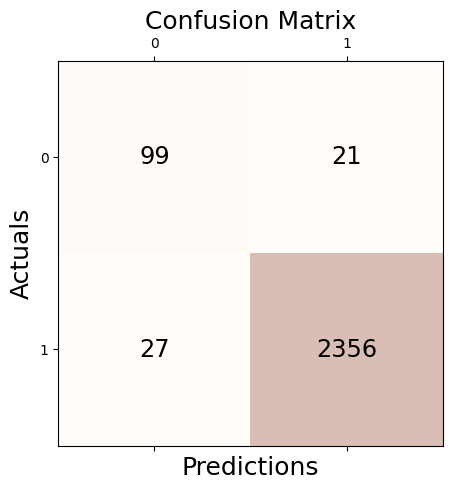

Accuracy: 0.981
Precision: 0.991
Recall: 0.989
F1 Score: 0.990

In [205]:
_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [206]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [207]:
clf.fit(X)

In [208]:
outlier_OSVM_one = list(clf.predict(X))

In [209]:
_conf = Conf_matrx(outlier_true_one_2,outlier_OSVM_one)

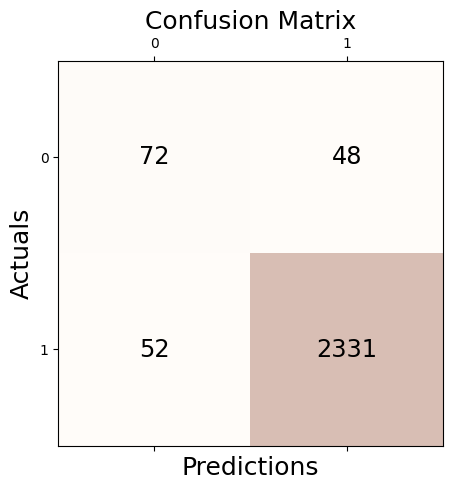

Accuracy: 0.960
Precision: 0.980
Recall: 0.978
F1 Score: 0.979

In [210]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [211]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x', 'y','fnoise']])
_df['MCD_clf'] = clf.labels_

In [212]:
outlier_MCD_one = list(clf.labels_)

In [213]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [214]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MCD_one)

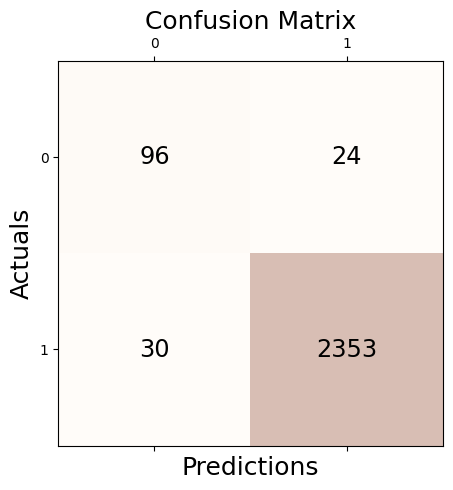

Accuracy: 0.978
Precision: 0.990
Recall: 0.987
F1 Score: 0.989

In [215]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [216]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['FeatureBagging_clf'] = clf.labels_

In [217]:
outlier_FeatureBagging_one = list(clf.labels_)

In [218]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [219]:
_conf = Conf_matrx(outlier_true_one_2,outlier_FeatureBagging_one)

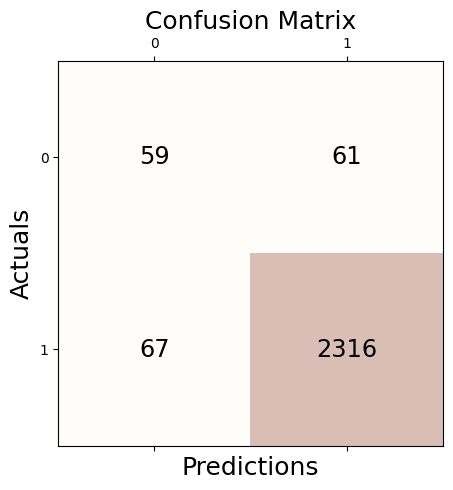

Accuracy: 0.949
Precision: 0.974
Recall: 0.972
F1 Score: 0.973

In [220]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [221]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['ABOD_Clf'] = clf.labels_

In [222]:
outlier_ABOD_one = list(clf.labels_)

In [223]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [224]:
_conf = Conf_matrx(outlier_true_one_2,outlier_ABOD_one)

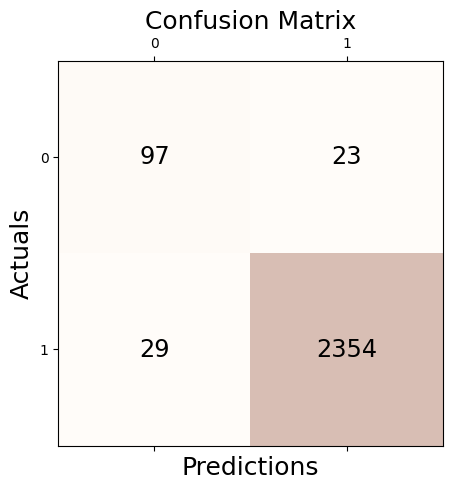

Accuracy: 0.979
Precision: 0.990
Recall: 0.988
F1 Score: 0.989

In [225]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [226]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [227]:
od.fit(_df[['x', 'y','fnoise']])

In [228]:
preds = od.predict(
    _df[['x', 'y','fnoise']],
    return_instance_score=True
)

In [229]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [230]:
outlier_alibi_one = _df['IF_alibi']

In [231]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [232]:
_conf = Conf_matrx(outlier_true_one_2,outlier_alibi_one)

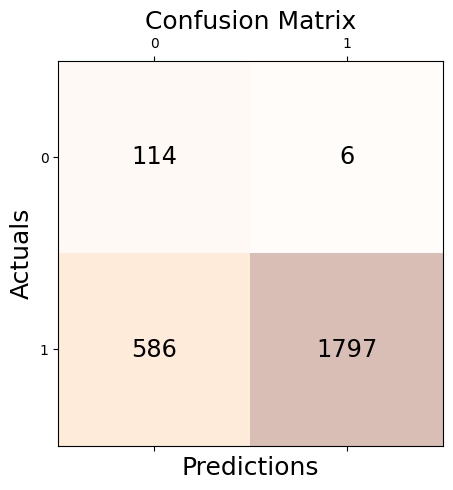

Accuracy: 0.763
Precision: 0.997
Recall: 0.754
F1 Score: 0.859

In [233]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [234]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['HBOS_clf'] = clf.labels_

In [235]:
outlier_HBOS_one = list(clf.labels_)

In [236]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [237]:
_conf = Conf_matrx(outlier_true_one_2,outlier_HBOS_one)

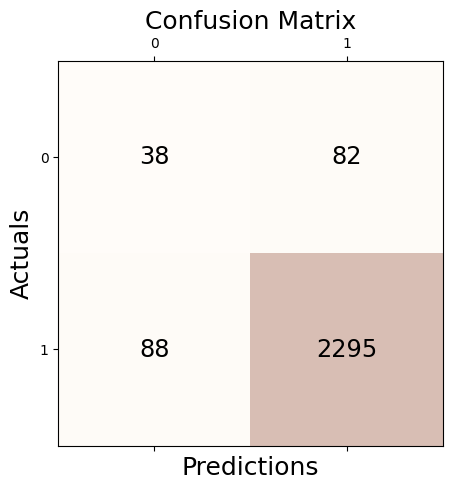

Accuracy: 0.932
Precision: 0.966
Recall: 0.963
F1 Score: 0.964

In [238]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [239]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['SOS_clf'] = clf.labels_

In [240]:
outlier_SOS_one = list(clf.labels_)

In [241]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [242]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SOS_one)

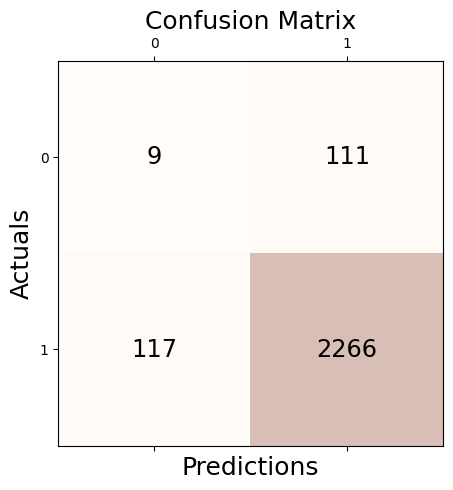

Accuracy: 0.909
Precision: 0.953
Recall: 0.951
F1 Score: 0.952

In [243]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [244]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

In [245]:
outlier_SO_GAAL_one = list(clf.labels_)

In [246]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [247]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SO_GAAL_one)

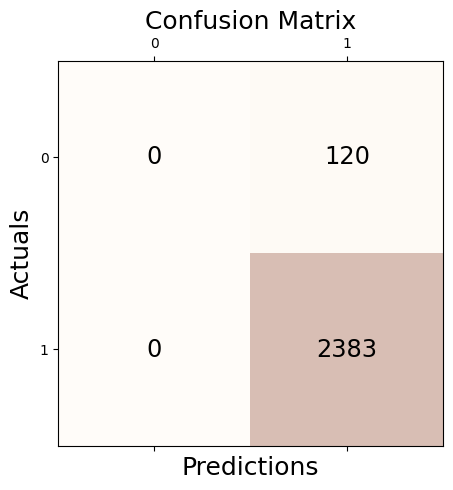

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975

In [248]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [249]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
79/79 [==============================] - 0s 2ms/step

Testing for epoch 1 index 2:
79/79 [==============================] - 0s 2ms/step

Testing for epoch 1 index 3:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 1 index 4:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 1 index 5:
79/79 [==============================] - 0s 2ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
79/79 [==============================] - 0s 2ms/step

Testing for epoch 2 index 2:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 3:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 4:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 5:
79/79 [==============================] - 0s 1ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
79/79 [==============================] - 0s 2ms/step

Testing for epoch 3 index 2:
79/79 [========

In [250]:
outlier_MO_GAAL_one = list(clf.labels_)

In [251]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [252]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MO_GAAL_one)

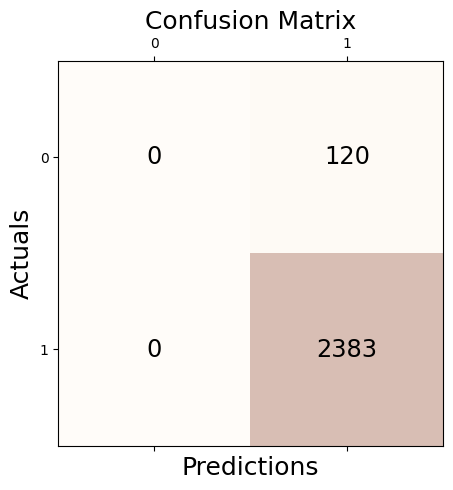

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975

In [253]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [254]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [255]:
outlier_LSCP_one = list(clf.labels_)

In [256]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [257]:
_conf = Conf_matrx(outlier_true_one_2,outlier_LSCP_one)

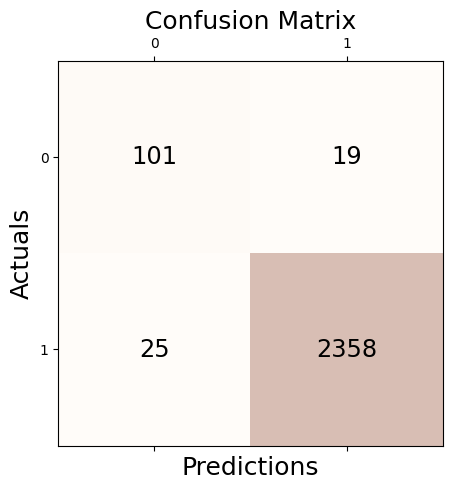

Accuracy: 0.982
Precision: 0.992
Recall: 0.990
F1 Score: 0.991

In [258]:
_conf.conf("LSCP (Zhao et al., 2019)")

# Real Data(Earthquake)

In [259]:
class earthquake_func:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.4,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.6
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visf(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='MagnitudeHat', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z=[0] * len(self.df), 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.7
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [260]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
        self.tab = tab
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)

## load data and clean it

`-` load

In [261]:
df_global= pd.concat([pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

`-` cleaning

In [262]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [263]:
df_global.Year = df_global.Year.astype(np.float64)

In [264]:
df_global_10 = df_global.copy()
df_global_10 = df_global_10.query("2010 <= Year < 2015").reset_index().iloc[:,1:];df_global_10

### GODE

In [265]:
gode_global = earthquake_func(df_global_10)

`-` get distance

In [266]:
gode_global.get_distance()

100%|██████████| 12498/12498 [09:15<00:00, 22.52it/s] 

In [267]:
gode_global.D[gode_global.D>0].mean()

`-` weight matrix

In [268]:
gode_global.get_weightmatrix(theta=(gode_global.D[gode_global.D>0].mean()),kappa=2500) 

`-` fit

In [ ]:
gode_global.fit()

In [320]:
_df = gode_global.df.copy()

In [321]:
outlier_simul_one = (_df['Residual']**2).tolist()

In [322]:
outlier_simul_one = list(map(lambda x: -1 if x > 0.04 else 1,outlier_simul_one))

### LOF

In [323]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [324]:
lof_rst = clf.fit_predict(_df)

### KNN

In [325]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['Latitude', 'Longitude','Magnitude']])

In [326]:
outlier_KNN_one = list(clf.labels_)

In [327]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

### CBLOF

In [328]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(df_global_10[['Latitude', 'Longitude','Magnitude']])
df_global_10['CBLOF_Clf'] = clf.labels_

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [329]:
outlier_CBLOF_one = list(clf.labels_)

In [330]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [331]:
outlier_CBLOF_one_t = pd.DataFrame([outlier_CBLOF_one]).T.rename(columns={0:'CBLOF'})

### OCSVM

In [332]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [333]:
clf.fit(_df)

In [334]:
outlier_OSVM_one = list(clf.predict(_df))

### MCD

In [335]:
clf = MCD(contamination=0.05, random_state = 77)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

In [336]:
outlier_MCD_one = list(clf.labels_)

In [337]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

### Feature Bagging

In [338]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['Latitude','Longitude','Magnitude']])
# _df['FeatureBagging_clf'] = clf.labels_

In [339]:
outlier_FeatureBagging_one = list(clf.labels_)

In [340]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

### ABOD

In [341]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

In [342]:
outlier_ABOD_one = list(clf.labels_)

In [343]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

### IForest

In [344]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [345]:
od.fit(_df[['Latitude','Longitude','Magnitude']])

In [346]:
preds = od.predict(
    _df[['Latitude','Longitude','Magnitude']],
    return_instance_score=True
)

In [347]:
outlier_alibi_one = preds['data']['is_outlier']

In [348]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

### HBOS

In [349]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

In [350]:
outlier_HBOS_one = list(clf.labels_)

In [351]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

### SOS

In [352]:
np.random.seed(77)
clf = SOS(contamination=0.05)

In [353]:
clf.fit(_df[['Latitude','Longitude','Magnitude']])

In [354]:
outlier_SOS_one = list(clf.labels_)

In [355]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

### SO_GAAL

In [356]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:

Testing for epoch 2 index 6:

Testing for epoch 2 index 7:

Testing for epoch 2 index 

In [357]:
outlier_SO_GAAL_one = list(clf.labels_)

In [358]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

### MO_GAAL

In [359]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
391/391 [==============================] - 1s 1ms/step

Testing for epoch 1 index 2:
391/391 [==============================] - 0s 1ms/step

Testing for epoch 1 index 3:
391/391 [==============================] - 0s 984us/step

Testing for epoch 1 index 4:
391/391 [==============================] - 0s 1ms/step

Testing for epoch 1 index 5:
391/391 [==============================] - 0s 1ms/step

Testing for epoch 1 index 6:
391/391 [==============================] - 1s 1ms/step

Testing for epoch 1 index 7:
391/391 [==============================] - 0s 1ms/step

Testing for epoch 1 index 8:
391/391 [==============================] - 0s 998us/step

Testing for epoch 1 index 9:
391/391 [==============================] - 1s 1ms/step

Testing for epoch 1 index 10:
391/391 [==============================] - 0s 1ms/step

Testing for epoch 1 index 11:
391/391 [==============================] - 1s 1ms/step

Testing for epoch 1 index 12:
391/391 [=====

In [360]:
outlier_MO_GAAL_one = list(clf.labels_)

In [361]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

### LSCP

In [362]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['Latitude','Longitude','Magnitude']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scip

In [363]:
outlier_LSCP_one = list(clf.labels_)

In [364]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

## Result

In [369]:
_df_compa = pd.concat([_df,pd.DataFrame(_df['Residual']**2).rename(columns={'Residual':'rst'}),pd.DataFrame(outlier_simul_one),
          pd.DataFrame(lof_rst).rename(columns={0:'LOF'}),
          pd.DataFrame(outlier_KNN_one).rename(columns={0:'KNN'}),
          pd.DataFrame([outlier_CBLOF_one]).T.rename(columns={0:'CBLOF'}),             
          pd.DataFrame(outlier_OSVM_one).rename(columns={0:'OCSVM'}),
          pd.DataFrame(outlier_MCD_one).rename(columns={0:'MCD'}),
          pd.DataFrame(outlier_FeatureBagging_one).rename(columns={0:'Feature Bagging'}),
          pd.DataFrame(outlier_ABOD_one).rename(columns={0:'ABOD'}),
          pd.DataFrame(outlier_alibi_one).rename(columns={0:'IForest'}),
          pd.DataFrame(outlier_HBOS_one).rename(columns={0:'HBOS'}),
          pd.DataFrame(outlier_SOS_one).rename(columns={0:'SOS'}),
          pd.DataFrame(outlier_SO_GAAL_one).rename(columns={0:'SO_GAAL'}),
          pd.DataFrame(outlier_MO_GAAL_one).rename(columns={0:'MO_GAAL'}),
          pd.DataFrame(outlier_LSCP_one).rename(columns={0:'LSCP'})],axis=1).\
          rename(columns={'Latitude':'Latitude',
                          'Longitude':'Longitude',
                          'Magnitude':'Magnitude',
                          'Year':'Year',
                          'MagnitudeHat':'MagnitudeHat',
                          'Residual':'Residual',
                          'rst':'Anomalious Score',
                          0:'GODE',
                          'LOF':'LOF',
                         'KNN':'KNN',
                          'CBLOF':'CBLOF',
                         'OCSVM':'OCSVM',
                         'MCD':'MCD',
                         'Feature Bagging':'Feature Bagging',
                         'ABOD':'ABOD',
                         'IForest':'IForest',
                         'HBOS':'HBOS',
                         'SOS':'SOS',
                         'SO_GAAL':'SO_GAAL',
                         'MO_GAAL':'MO_GAAL',
                         'LSCP':'LSCP'});_df_compa

#### Haiti

***GODE, LOF, Feature Bagging, ABOD, IForest, HBOS***

In [370]:
_df_compa[_df_compa['Latitude']==18.443] # Haiti(lat=18.4430, lon=-72.5710)

#### Iquique

***GODE, IForest, HBOS***

In [371]:
_df_compa[_df_compa['Latitude']==-32.6953] # Iquique lat=-32.6953, lon=-71.4416

#### Sichan

***GODE, Feature Bagging, ABOD, IForest, HBOS, SOS***

In [372]:
_df_compa[_df_compa['Latitude']==30.3080] # sichan(lat=30.3080, lon=102.8880)